# Natural Language Processing project - Emotional Dialogues dataset

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import shutil
from IPython.display import FileLink

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from transformers import AdamWeightDecay
from datasets import Dataset, DatasetDict

import tensorflow as tf
from tensorflow.keras.optimizers.schedules import PolynomialDecay
print(tf.__version__)
print(tf.config.list_physical_devices())

# startegy for training on multiple gpus
mirrored_strategy = tf.distribute.MirroredStrategy()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.11.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

dataset = pd.read_csv('../input/edos-1m/EDOS 1M.csv')

X,y = dataset["uttr"], dataset["eb+_emot"]

print(X.head(5))
print(type(X), end="\n\n")
print(y.head(5))
print(type(y), end="\n\n")

classes = y.unique()
classes

0    You moron ! What fool washes diapers by the we...
1                                   You useless fool !
2                                 How dare you sleep !
3                        Up ! Go and clean the house .
4                                  Clean the kitchen .
Name: uttr, dtype: object
<class 'pandas.core.series.Series'>

0       angry
1     furious
2     furious
3    prepared
4    prepared
Name: eb+_emot, dtype: object
<class 'pandas.core.series.Series'>



array(['angry', 'furious', 'prepared', 'acknowledging', 'trusting',
       'confident', 'hopeful', 'caring', 'sentimental', 'anticipating',
       'wishing', 'surprised', 'ashamed', 'questioning', 'sad',
       'nostalgic', 'devastated', 'terrified', 'embarrassed', 'lonely',
       'encouraging', 'suggesting', 'content', 'afraid', 'impressed',
       'agreeing', 'apprehensive', 'proud', 'annoyed', 'anxious',
       'grateful', 'excited', 'neutral', 'faithful', 'guilty',
       'consoling', 'disgusted', 'disappointed', 'jealous', 'joyful',
       'sympathizing'], dtype=object)

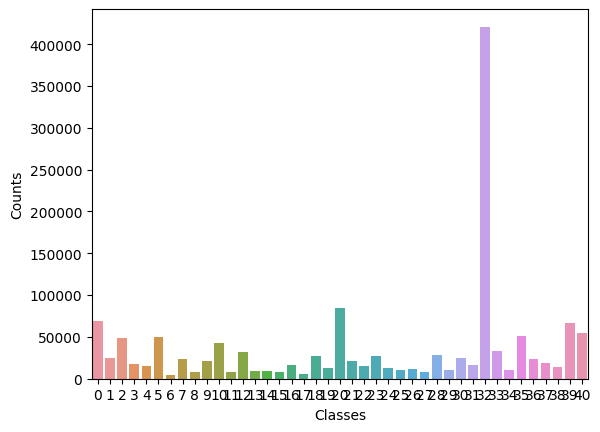

In [ ]:
# plot classes distribution
counts = pd.get_dummies(y).sum()

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = [i for i in range(len(classes))], y = counts)
plt.show()

In [ ]:
# train, validation and test split
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, stratify=y)

print("train size: ", len(train_X))
print("validation size: ", len(valid_X))

train size:  990299
validation size:  424414


In [ ]:
# support function to compute top-k accuracy
def top_k_accuracy(true_y, pred_y, k):
    # Get the top k predictions for each sample in the validation dataset
    pred_y_top_k = np.argsort(pred_y, axis=1)[:, -k:]

    # Get the ground truth labels for the validation dataset
    true_labels = np.asarray(true_y)

    # Compute top k accuracy
    top_k_accuracy = np.mean(np.any(pred_y_top_k == true_labels.reshape(true_labels.shape[0], 1), axis=1))
    return f"Top-{k} accuracy: " + str(top_k_accuracy)